In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`


In [2]:
using ModelingToolkit
using Plots
using DifferentialEquations

Solving Lotka-Volterra
$$
\begin{align}
\dfrac{dx}{dt} &= \alpha x - \beta x y \\
\dfrac{dy}{dt} &= -\gamma y + \delta xy \\
z(t) &= x(t) + y(t)
\end{align}
$$

In [3]:
# Define our state variables: state(t) = initial condition
@variables t x(t)=1 y(t)=1 z(t)=2

# Define our parameters
@parameters α=1.5 β=1.0 γ=3.0 δ=1.0

# Define our differential: takes the derivative with respect to `t`
D = Differential(t)

# Define the differential equations
eqs = [D(x) ~ α * x - β * x * y
       D(y) ~ -γ * y + δ * x * y
       z ~ x + y]

# Bring these pieces together into an ODESystem with independent variable t
@named sys = ODESystem(eqs, t)

# Symbolically Simplify the System
simpsys = structural_simplify(sys)

# Convert from a symbolic to a numerical problem to simulate
tspan = (0.0, 10.0)
prob = ODEProblem(simpsys, [], tspan)

# Solve the ODE
sol = solve(prob);

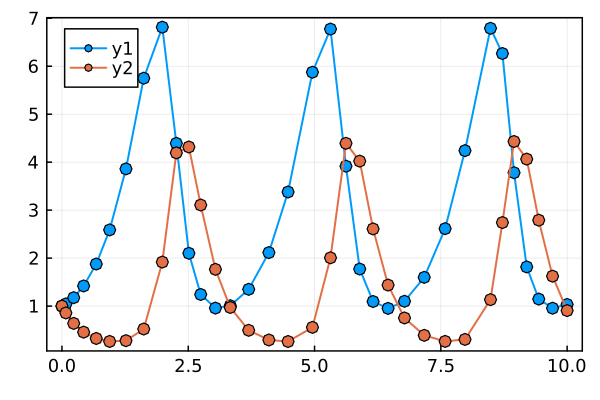

In [37]:
p = plot(thickness_scaling=1.5, framestyle=:box)
plot!(sol.t, reduce(hcat, sol.u)', marker=:o, lw=4/3)

# PDE solver

Solving the Brusselator PDE defined as:
$$
\begin{align}
\partial_t u(\mathbf{r}, t) &= 1 + u^2 v - c_1 u + \alpha \nabla^2 u + f(\mathbf{r}, t) \\
\partial_t v(\mathbf{r}, t) &= c_2 u - u^2 v + \alpha \nabla^2 v\\
\end{align}
$$
with $c_1 = 4.4, c_2 = 3.4$, $\mathbf{r} = (x, y)$
$$
f(\mathbf{x}, t) = \begin{cases} 5 & \mathrm{if} \ (x - 0.3)^2 + (y - 0.6)^2 \leq 10^{-2} \ \mathrm{and} \ t \geq 1.1 \\
0 & \mathrm{else}
\end{cases}.
$$

Initial conditions are
$$
\begin{align}
u(\mathbf{r}, 0) &= 22 (y (1 - y))^{3/2} \\
v(\mathbf{r}, 0) &= 27 (x (1 - x))^{3/2} \\
\end{align}
$$

We assume periodic boundary conditions and solve for $t \in [0, 11.5]$.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`


In [2]:
using ModelingToolkit
using MethodOfLines
using OrdinaryDiffEq
using LinearSolve
using DomainSets
using Plots
using BenchmarkTools

## Defining the symbolic PDEsystem with `ModelingToolkit.jl`

In [3]:
c1 = 4.4
c2 = 3.4
α = 10.0

@parameters x y t
@variables u(..) v(..)
Dt = Differential(t)
Dx = Differential(x)
Dy = Differential(y)
Dxx = Differential(x)^2
Dyy = Differential(y)^2
∇²(u) = Dxx(u) + Dyy(u)

bruss_f(x, y, t) = 5 * (((x - 0.3)^2 + (y - 0.6)^2) <= 1e-2) * (t >= 1.1)

x_min = y_min = t_min = 0.0
x_max = y_max = 1.0
t_max = 11.5

# initial conditions
u0(x, y, t) = 22 * (y * (1 - y))^(3/2)
v0(x, y, t) = 27 * (x * (1 - x))^(3/2)

# equations of motion
eq = [Dt(u(x, y, t)) ~ 1.0  + v(x, y, t) * u(x, y, t)^2 - c1 * u(x, y, t) + α * ∇²(u(x, y, t)) + bruss_f(x, y, t),
      Dt(v(x, y, t)) ~ c2 * u(x, y, t) - v(x, y, t) * u(x, y, t)^2 + α * ∇²(v(x, y, t))]

# domain
domains = [x ∈ Interval(x_min, x_max),
           y ∈ Interval(y_min, y_max),
           t ∈ Interval(t_min, t_max)]

# boundary conditions
bcs = [u(x, y, 0) ~ u0(x, y, 0),
       u(0, y, t) ~ u(1, y ,t),
       u(x, 0, t) ~ u(x, 1 ,t),
       v(x, y, 0) ~ v0(x, y, 0),
       v(0, y, t) ~ v(1, y ,t),
       v(x, 0, t) ~ v(x, 1 ,t)]

@named pdesys = PDESystem(eq, bcs, domains, [x, y, t], [u(x, y, t), v(x, y, t)])

PDESystem
Equations: Equation[Differential(t)(u(x, y, t)) ~ 1.0 + 10.0(Differential(x)(Differential(x)(u(x, y, t))) + Differential(y)(Differential(y)(u(x, y, t)))) - 4.4u(x, y, t) + 5(((-0.3 + x)^2 + (-0.6 + y)^2) <= 0.01)*(t >= 1.1) + (u(x, y, t)^2)*v(x, y, t), Differential(t)(v(x, y, t)) ~ 10.0(Differential(x)(Differential(x)(v(x, y, t))) + Differential(y)(Differential(y)(v(x, y, t)))) + 3.4u(x, y, t) - (u(x, y, t)^2)*v(x, y, t)]
Boundary Conditions: Equation[u(x, y, 0) ~ 22.0(y^1.5)*((1 - y)^1.5), u(0, y, t) ~ u(1, y, t), u(x, 0, t) ~ u(x, 1, t), v(x, y, 0) ~ 27.0((1 - x)^1.5)*(x^1.5), v(0, y, t) ~ v(1, y, t), v(x, 0, t) ~ v(x, 1, t)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0), Symbolics.VarDomainPairing(t, 0.0 .. 11.5)]
Dependent Variables: Num[u(x, y, t), v(x, y, t)]
Independent Variables: Num[x, y, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

## Automated symbolic discretization with `MethodOfLines.jl`

Have to translate the symbolic equation into a discrete, numerical problem. The goal will be to use finite differences in $(x, y)$ to create a system of ODEs for $u_i(t) \equiv u(x_i, y_i, t)$ where $i \in \mathbb{Z}^2$.

To do this, we use the `MOLFiniteDifference` construct of `MethodOfLines.jl`.

In [4]:
N = 32
order = 2

dx = (x_max - x_min) / N
dy = (y_max - y_min) / N

discretization = MOLFiniteDifference([x => dx, y => dy], t,
                                     approx_order=order,
                                     grid_align=center_align)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Float64}(y => 0.03125, x => 0.03125), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

Now we `discretize` the system, converting the `PDESystem` to an `ODEProblem`

In [5]:
prob = discretize(pdesys, discretization);

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:39


## Solving the PDE

Now we solve with an appropriate ODE solver. This is the same as `DifferentialEquations.jl`

In [6]:
sol = solve(prob, TRBDF2(), saveat=0.1);

Get the values of $(x, y, t)$ where the solution was found

In [7]:
discrete_x = sol[x];
discrete_y = sol[y];
discrete_t = sol[t];

Get the results from $u$ and $v$ by indexing by the dependent variable

In [8]:
sol_u = sol[u(x, y, t)];
sol_v = sol[v(x, y, t)];

[ Info: Saved animation to /Users/danny/code/uchicago/sociohydro/sim/meanField/SchellingMF/tmp.gif


Plots.AnimatedGif("/Users/danny/code/uchicago/sociohydro/sim/meanField/SchellingMF/tmp.gif")
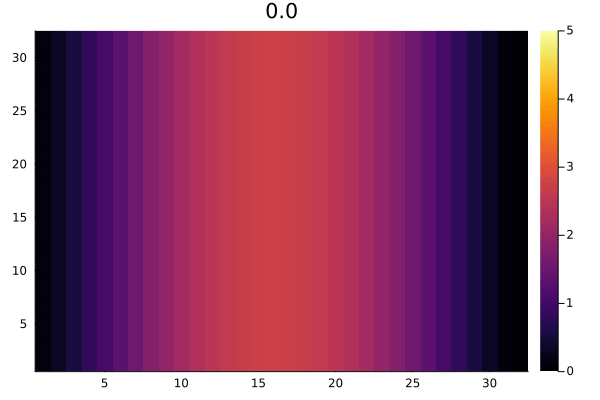

In [9]:
anim = @gif for k in 1:length(discrete_t)
    heatmap(sol_u[2:end, 2:end, k], title="$(discrete_t[k])", clim=(0, 5))
end

## Improving solution process

Here we improve the speed of the solutions. We first do this by passing certain construction options to the `discretize` call.

In [10]:
prob_sparse = discretize(pdesys, discretization; jac=true, sparse=true)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:39


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 11.5)
u0: 2048-element Vector{Float64}:
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 0.11588181443634263
 ⋮
 2.892889192682502
 2.688734070638931
 2.453970555156994
 2.1921268033293604
 1.9075279151581102
 1.605464573318729
 1.2924521756218903
 0.9766542925609525
 0.668640545523243
 0.3829487927768564
 0.1422185904446023
 0.0

In [13]:
@btime sol = solve(prob, TRBDF2(), saveat=0.1);
@btime sol = solve(prob_sparse, TRBDF2(), saveat=0.1);

  5.279 s (2490155 allocations: 301.34 MiB)
  1.316 s (2490100 allocations: 436.38 MiB)


Improve futher by using a different solver, namely a Newton-Krylov method

In [15]:
@btime sol = solve(prob_sparse, TRBDF2(linsolve = KrylovJL_GMRES()), saveat=0.1);

  3.160 s (2731023 allocations: 290.90 MiB)
